___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Churn Prediction for Bank Customer<br><h1>

# Overview

In this project we're going to build a nueral network model for customers churn prediction using a dataset of bank customers.
The goal of this notebook is to predict if a customer is going to close his/her account or not. 

Dataset description:

- **rownumber:** Row Numbers from 1 to 10000.
- **customerid:** A unique ID that identifies each customer.
- **surname:** The customer’s surname.
- **creditscore:** A credit score is a number between 300–850 that depicts a consumer's creditworthiness.
- **geography:** The country from which the customer belongs to.
- **Gender:** The customer’s gender: Male, Female
- **Age:** The customer’s current age, in years, at the time of being customer.
- **tenure:** The number of years for which the customer has been with the bank.
- **balance:** Bank balance of the customer.
- **numofproducts:** the number of bank products the customer is utilising.
- **hascrcard:** The number of credit cards given to the customer by the bank.
- **isactivemember:** Binary Flag for indicating if the client is active or not with the bank before the moment where the client exits the company (recorded in the variable "exited")
- **exited:** Binary flag 1 if the customer closed account with bank and 0 if the customer is retained.

# Improt Libraries & Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, ConfusionMatrixDisplay,\
RocCurveDisplay, roc_auc_score,roc_curve
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import pickle
import warnings
import os
import optuna

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
sns.set_style('whitegrid')

In [3]:
tf.__version__

'2.14.0'

In [4]:
optuna.__version__

'3.4.0'

In [5]:
df = pd.read_csv('Churn_Modelling.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


# Exploratory Data Analysis and Visualization

In this section we will explore and visualize the data to get a better idea about the features we're going to work with.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
# checking for duplicates
df.duplicated().sum()

0

In [8]:
# checking for nulls 
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Dropping irrelavant features

In [9]:
# these features are irrelavant and cannot be used for prediction 
features_to_drop = ['RowNumber', 'CustomerId', 'Surname']

In [10]:
# dropping the features
df = df.drop(features_to_drop, axis=1)

### EDA

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


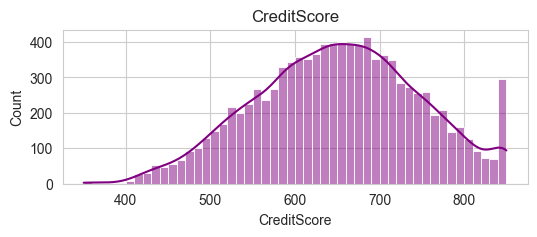

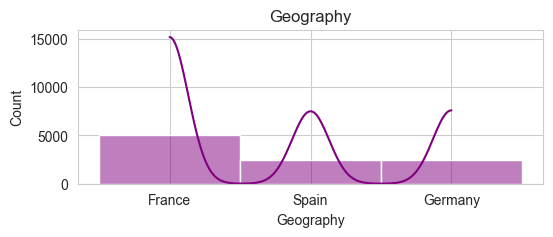

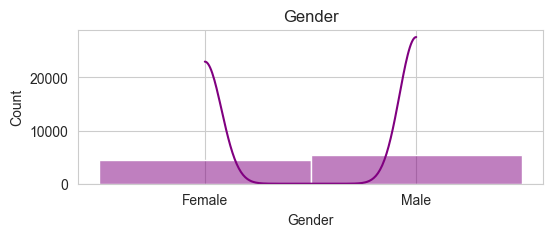

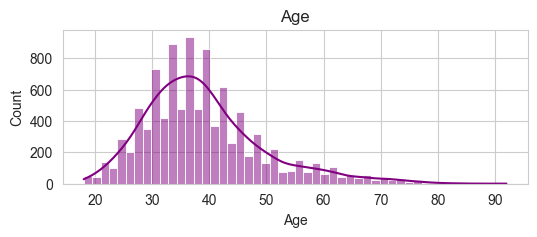

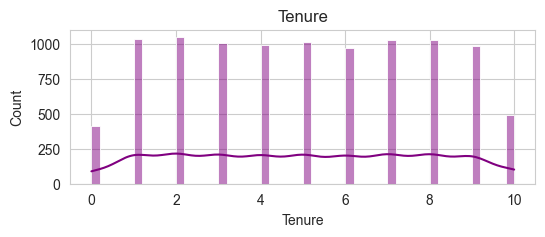

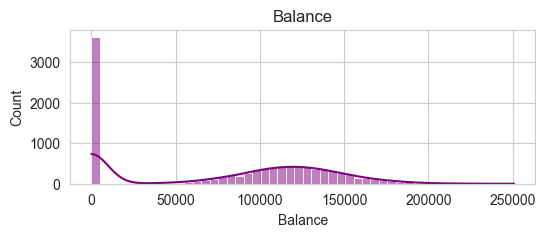

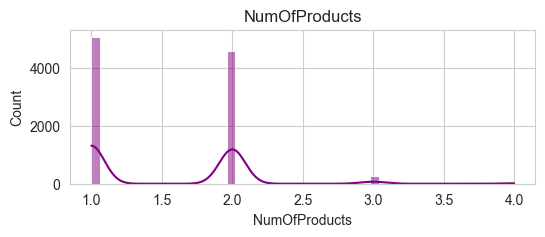

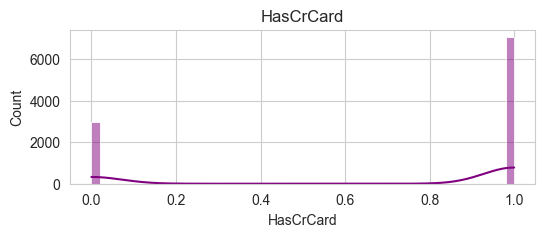

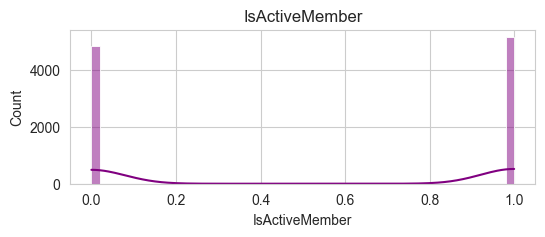

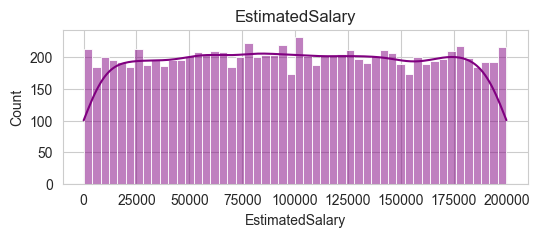

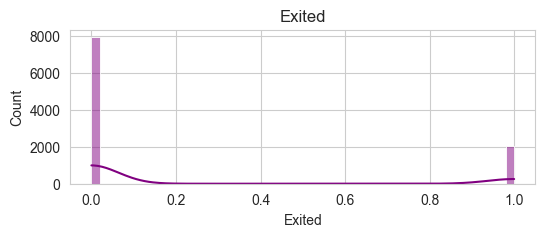

In [12]:
# visualizing the dist of columns
for column in df:
        plt.figure(figsize=(6,2))
        sns.histplot(df[column], bins=50, kde=True, color= 'purple')
        plt.title(f'{column}');

In [13]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [14]:
df.describe(include='object').T

,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


In [15]:
df.groupby(['Gender']).mean()['CreditScore'].sort_values()

Gender
Male      650.276892
Female    650.831389
Name: CreditScore, dtype: float64

In [16]:
df.groupby(['Gender']).mean()['Balance'].sort_values()

Gender
Female    75659.369139
Male      77173.974506
Name: Balance, dtype: float64

In [17]:
df.groupby(['Gender']).mean()['EstimatedSalary'].sort_values()

Gender
Male       99664.576931
Female    100601.541382
Name: EstimatedSalary, dtype: float64

Not a huge difference between male and female in Salary, balance, and credit scores

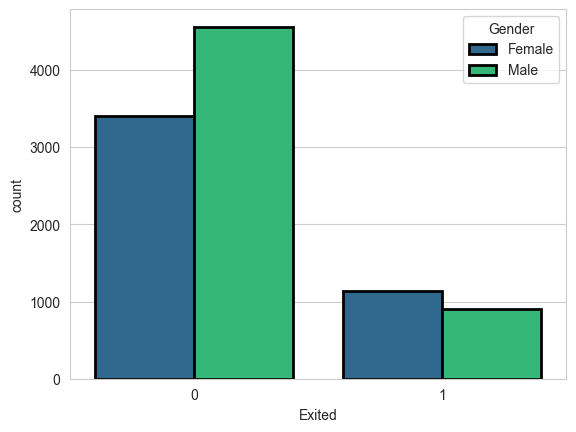

In [18]:
sns.countplot(x='Exited', hue='Gender', data=df,saturation=1, edgecolor='k',
            linewidth=2, palette= 'viridis')
plt.show()

Females have closed thier accounts more than males.

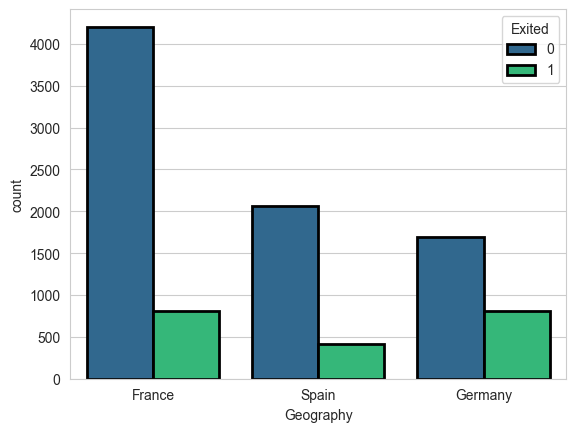

In [19]:
sns.countplot(x='Geography', hue='Exited', data=df,saturation=1, edgecolor='k',
            linewidth=2, palette= 'viridis')
plt.show()

Both Germany and France have similar count for Exited

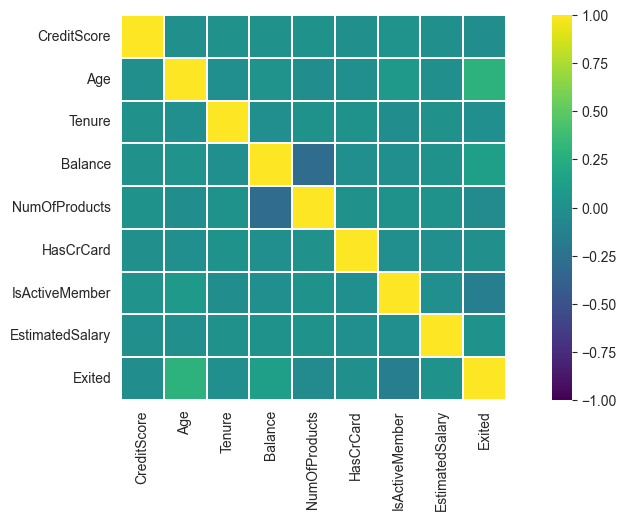

In [20]:
# correlation heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(df.corr(numeric_only=True), 
            vmin=-1,
            vmax= 1,
            cmap= 'viridis', 
            linewidths=.12, 
            linecolor='white',
            fmt='.2g',
            square=True);

No features with high correlation scores

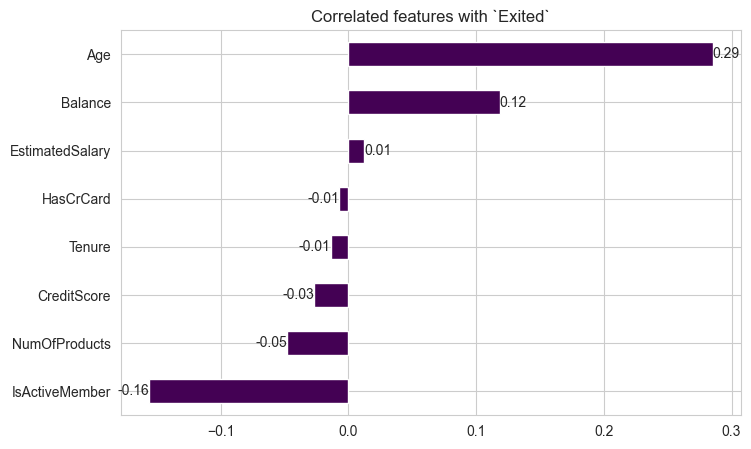

In [21]:
# correlated features with `Exited`
plt.figure(figsize=(8, 5))
ax = df.corr()['Exited'][:-1].sort_values().plot(kind='barh', colormap='viridis')
ax.bar_label(ax.containers[0], fmt="%.2f")
plt.title('Correlated features with `Exited`');

The `Age` and `Balance` are the most correlated features with our target `Exited`

### Checking outliers

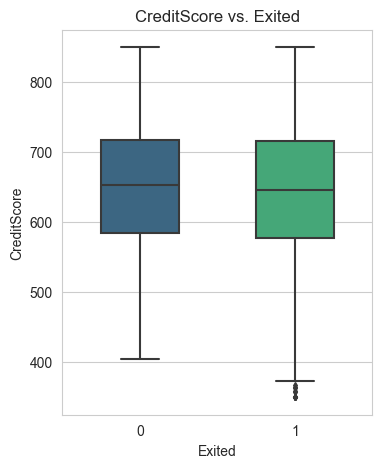

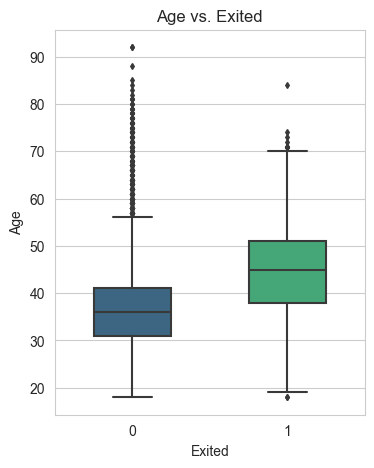

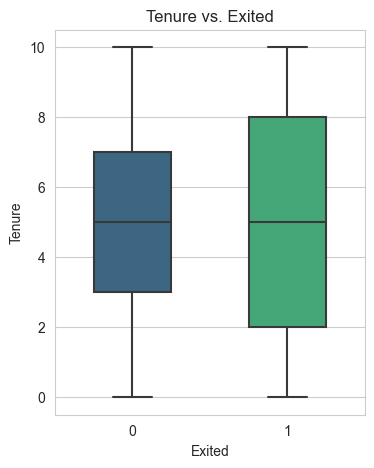

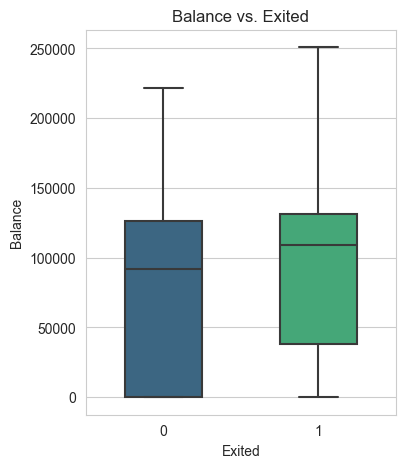

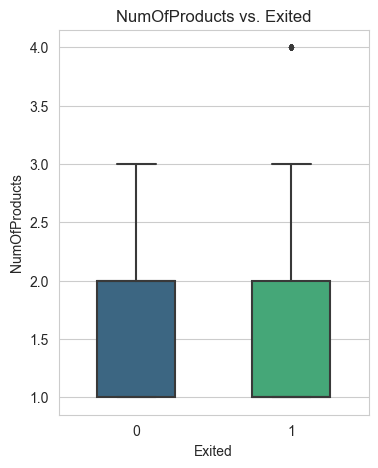

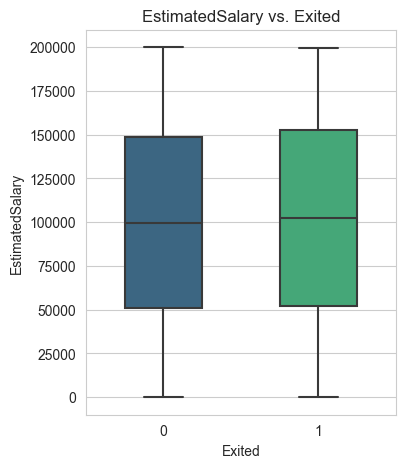

In [22]:
# store numerical columns names except target feature and categorical features
columns = list(df.select_dtypes(include='number').columns)

columns.remove('Exited') # binary
columns.remove('IsActiveMember') # binary
columns.remove('HasCrCard') #binary

for column in columns:
    plt.figure(figsize=(4, 5))
    sns.boxplot(data=df, width=0.5, fliersize=3, y=column, x='Exited', palette = 'viridis')
    plt.title(f'{column} vs. Exited')
    plt.show()

The effect of outliers can be unpredictable. we're gonna compare the results using Robust vs Standard vs MinMax scalers.

In [23]:
# features to be one-hot encoded
categorical_features = ['IsActiveMember', 'HasCrCard', 'Gender' ,'Geography']

### Target feature

In [24]:
c = df['Exited'].value_counts()

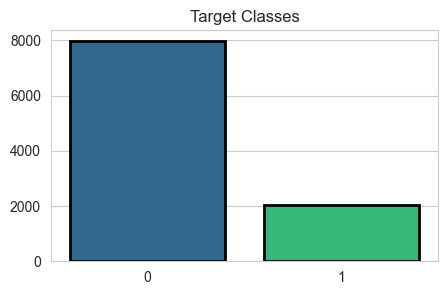

In [25]:
# visualizing our target distribution
plt.figure(figsize=(5, 3))
sns.barplot(x=c.index, y=c.values,
            saturation=1, edgecolor='k',
            linewidth=2, palette='viridis')
plt.title(f'Target Classes')
plt.show()

The target classes are not balanced, we must handle the imbalnced issue. <br>
Common approaches: 
- Focus on recall, precision, F1 scores for each class or (macro average)
- Use the class weight parameter to assign higher weights for the minority class

During the modeling process we will try to improve the performance for class 1 since it has more value in this business problem. 

## Column transformer

In [26]:
column_trans = make_column_transformer((
               OneHotEncoder( handle_unknown='ignore',
                              sparse_output=False), 
                              categorical_features),
                              remainder = 'passthrough', 
                              verbose_feature_names_out=False)

In [27]:
# we're gonna test three scalers
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# Preprocessing of Data
- Train | Test Split, Scalling

In [28]:
# splitting X and y
X = df.drop(columns = ['Exited'], axis=1)
y = df['Exited']

In [29]:
X.shape

(10000, 10)

to ensure that the validation set has similar dist of y classes we're gonna create validation set and resplit them.

In [30]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.1, stratify = y, random_state = 1010)

In [31]:
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size = 0.15, stratify = y_train, random_state = 1010)

In [32]:
# transforming X
X_train = column_trans.fit_transform(X_train)
X_test = column_trans.transform(X_test)
X_val = column_trans.transform(X_val)

To better understand the effect of scaler choice in deep learning; we're going to test the 3 scalers.

In [33]:
# robust scaler 
X_train = robust_scaler.fit_transform(X_train)
X_test = robust_scaler.transform(X_test)
X_val = robust_scaler.transform(X_val)

In [60]:
# Standard Scaler
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)
X_val = standard_scaler.transform(X_val)

In [33]:
# MinMax Scaler (final choice)
X_train = minmax_scaler.fit_transform(X_train)
X_test = minmax_scaler.transform(X_test)
X_val = minmax_scaler.transform(X_val)

In [34]:
X_train.shape

(7650, 15)

In [35]:
X_test.shape

(1000, 15)

we have 9000 samples for model training and 1000 for validation 

# Modelling & Model Performance

In [36]:
# to have fixed results everytime we run the code, we must set the same seed number for all packages
SEED = 101
import os
import random

def set_seed():
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    tf.keras.utils.set_random_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

### Scoring

In [37]:
def eval_metric(y_pred, y_test):
    '''
    Description:
    This function gets predicted values (probs) and ground true labels and print 
    the confusion matrix and classification report and ROC-AUC
    
    INPUT:
    model - fitted model
    X_test - input features for the testing set
    y_test - target values for testing set
    
    RETURN:
    Nothing

    '''
    y_pred_proba = y_pred
    y_pred = np.round(y_pred).flatten()  # round predictions to obtain binary labels

    print('Model Evaluation')
    print('--------------------------------------------------------')
    print(classification_report(y_test, y_pred))
    print()                    
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,normalize='true',cmap='GnBu')
    print()
    RocCurveDisplay.from_predictions(y_test, y_pred_proba)

## without class_weigth

### Create The Model

In [38]:
set_seed() # must reset the seed in each model's , otherwise it will produce diffrent results

# using keras Sequential API

# ann model archticture 
model = Sequential(
    [
        Input(shape = X_train.shape[1]), # input layer
        Dense(units = 20, activation = 'relu'), # hidden layer (1)
        Dense(units = 10, activation = 'relu'), # hidden layer (2)
        Dense(units = 1, activation ='sigmoid'), # output layer - binary classification
    ]
)

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                320       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 541 (2.11 KB)
Trainable params: 541 (2.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
optimizer = Adam()  # default alpha
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy']) # test intial performance with accuracy

In [41]:
model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), batch_size = 128, epochs = 200);

Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 0.5383 - accuracy: 0.7908 - val_loss: 0.5046 - val_accuracy: 0.7963
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.4906 - accuracy: 0.7963 - val_loss: 0.4822 - val_accuracy: 0.7963
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.4731 - accuracy: 0.7967 - val_loss: 0.4690 - val_accuracy: 0.7963
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 0.4635 - accuracy: 0.7983 - val_loss: 0.4625 - val_accuracy: 0.7941
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.4576 - accuracy: 0.8003 - val_loss: 0.4580 - val_accuracy: 0.7956
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.4524 - accuracy: 0.8018 - val_loss: 0.4550 - val_accuracy: 0.7963
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.4472 - accuracy: 0.8024 - val_loss: 0.4540 - val_accuracy: 0.8030
Epoch 8/200
6

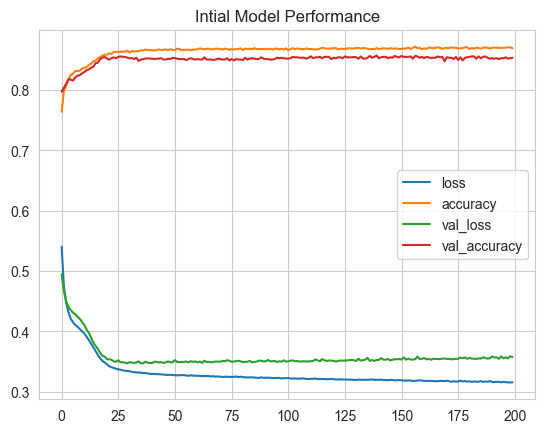

In [44]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('Intial Model Performance');

In [45]:
acc

,loss,accuracy,val_loss,val_accuracy
0,0.540679,0.763922,0.494587,0.797037
1,0.474580,0.797908,0.466616,0.803704
2,0.448121,0.806667,0.450206,0.810370
3,0.431718,0.817124,0.440501,0.817778
4,0.421275,0.824837,0.435583,0.817037
...,...,...,...,...
195,0.316584,0.869935,0.355659,0.852593
196,0.316133,0.870065,0.357142,0.854074
197,0.315668,0.870588,0.355452,0.851852
198,0.315550,0.870719,0.359092,0.852593


In [46]:
y_pred = model.predict(X_test) # the y_pred is in probablity format

32/32 [==============================] - 0s 1ms/step


Model Evaluation
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       796
           1       0.74      0.50      0.60       204

    accuracy                           0.86      1000
   macro avg       0.81      0.73      0.76      1000
weighted avg       0.85      0.86      0.85      1000





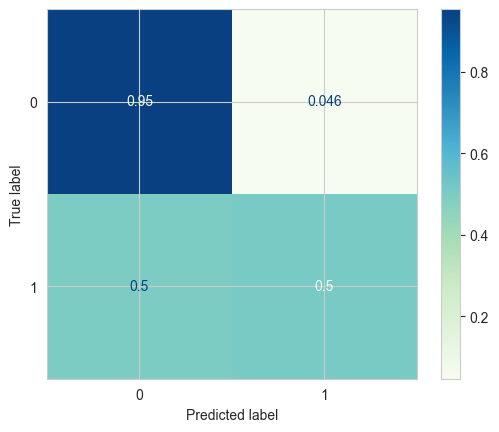

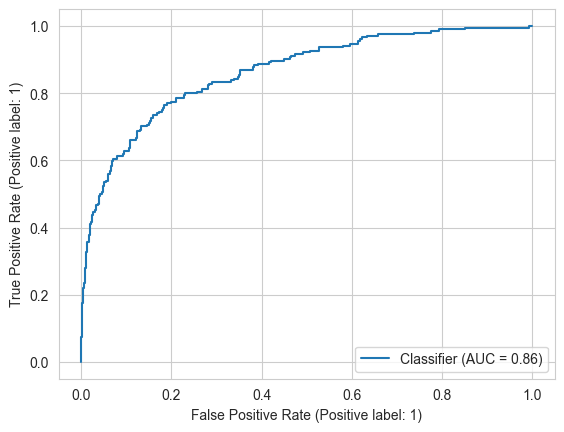

In [47]:
# robust scaller 
eval_metric(y_pred, y_test) 

Due to the imbalanced nature of labels, class 1 performed worse than class 0 

#### testing with minmax and standard scaler after training the above model and after re-configuring train set scaling

32/32 [==============================] - 0s 1ms/step
Model Evaluation
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       796
           1       0.78      0.53      0.63       204

    accuracy                           0.87      1000
   macro avg       0.83      0.75      0.78      1000
weighted avg       0.87      0.87      0.86      1000





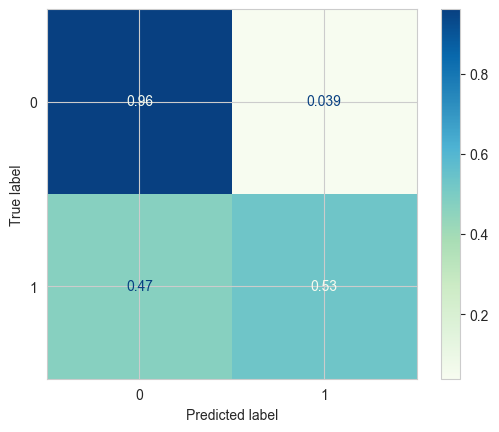

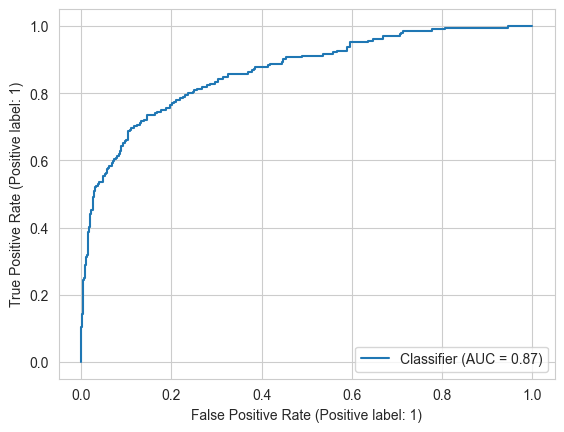

In [42]:
y_pred = model.predict(X_test) 
# MinMax scaller results
eval_metric(y_pred, y_test) 

32/32 [==============================] - 0s 2ms/step
Model Evaluation
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       796
           1       0.72      0.51      0.60       204

    accuracy                           0.86      1000
   macro avg       0.80      0.73      0.76      1000
weighted avg       0.85      0.86      0.85      1000





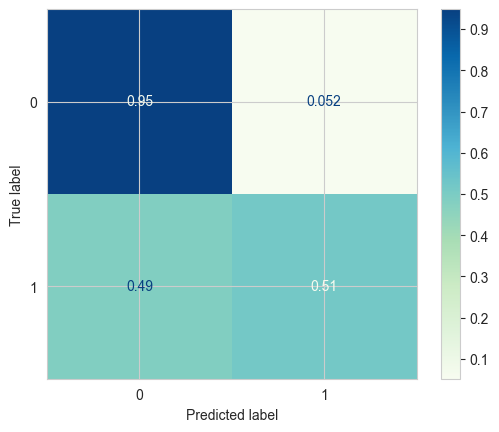

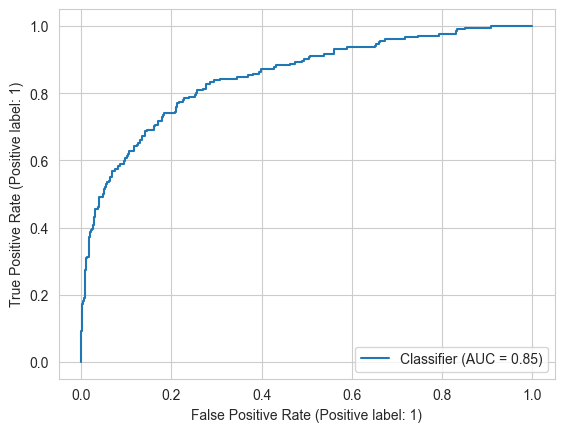

In [64]:
y_pred = model.predict(X_test) 
# Standard scaller results
eval_metric(y_pred, y_test) 

- The results are very close to each other
- MinMax and Robust scaling has the close results so the effect of outliers is not huge.
- For the rest of the steps we will go with MinMax scaler since it showed slightly better results. 

## with class_weigth


### Create The Model

In [43]:
set_seed() 

model = Sequential(
    [
        Input(shape = X_train.shape[1]), # input layer
        Dense(units = 20, activation = 'relu'), # hidden layer (1)
        Dense(units = 10, activation = 'relu'), # hidden layer (2)
        Dense(units = 1, activation ='sigmoid'), # output layer - binary classification
    ]
)

In [44]:
optimizer = Adam()  # default alpha
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall']) # to improve recall scores

In [45]:
# calculates the weights that make the classes balanced
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [46]:
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [47]:
class_weights

{0: 0.6278726198292843, 1: 2.4550706033376124}

In [48]:
model.fit(x = X_train, y = y_train, validation_data = (X_val,y_val),
           batch_size = 128, epochs = 200, class_weight=class_weights)

Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 0.6743 - recall: 0.5693 - val_loss: 0.6711 - val_recall: 0.6545
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6508 - recall: 0.6791 - val_loss: 0.6444 - val_recall: 0.6545
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6330 - recall: 0.6560 - val_loss: 0.6461 - val_recall: 0.7055
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6210 - recall: 0.6823 - val_loss: 0.6186 - val_recall: 0.6764
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6124 - recall: 0.6617 - val_loss: 0.6190 - val_recall: 0.6945
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6048 - recall: 0.6707 - val_loss: 0.6017 - val_recall: 0.6582
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5973 - recall: 0.6861 - val_loss: 0.5652 - val_recall: 0.6000
Epoch 8/200
60/60 [======================

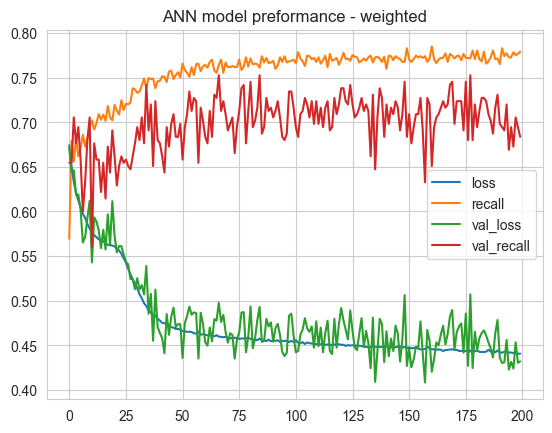

In [49]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('ANN model preformance - weighted');

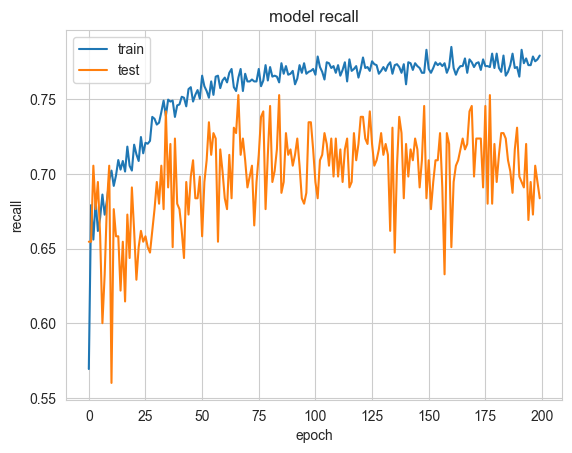

In [50]:
plt.plot(model.history.history['recall'])
plt.plot(model.history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The model is overfitting the data

32/32 [==============================] - 0s 1ms/step
Model Evaluation
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       796
           1       0.51      0.73      0.60       204

    accuracy                           0.80      1000
   macro avg       0.72      0.78      0.73      1000
weighted avg       0.84      0.80      0.81      1000





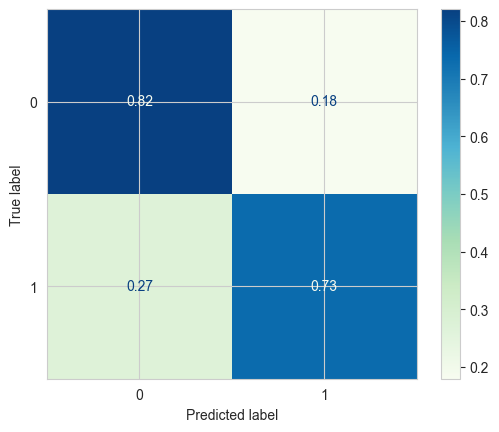

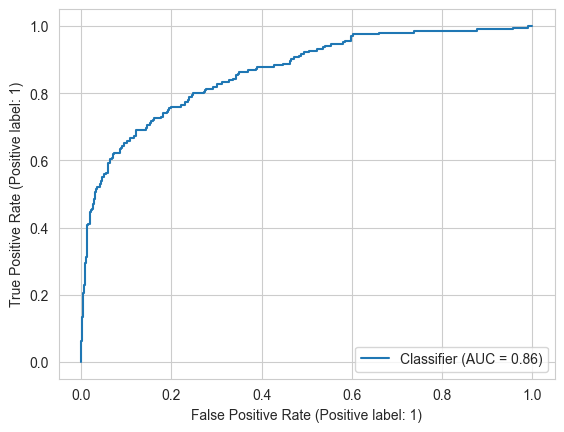

In [51]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

The Recall score for class 1 is better after assigning the weights

## Implementation Different Methods to Develop The Model

- Implement the following methods on model creating with "class_weight" parameter
- Create and evaluate model for each method 

### Increase The Learning Rate and Observe The Results

In [52]:
set_seed() 

model = Sequential(
    [
        Input(shape = X_train.shape[1]), # input layer
        Dense(units = 20, activation = 'relu'), # hidden layer (1)
        Dense(units = 10, activation = 'relu'), # hidden layer (2)
        Dense(units = 1, activation ='sigmoid'), # output layer - binary classification
    ]
)

optimizer = Adam(learning_rate=0.05)  
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])

In [53]:
model.fit(x = X_train, y = y_train, validation_data = (X_val,y_val),
           batch_size = 128, epochs = 200, class_weight=class_weights)

Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 0.6179 - recall: 0.6476 - val_loss: 0.5736 - val_recall: 0.5782
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5907 - recall: 0.6829 - val_loss: 0.6231 - val_recall: 0.7309
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5645 - recall: 0.6893 - val_loss: 0.7619 - val_recall: 0.8436
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5586 - recall: 0.7047 - val_loss: 0.4646 - val_recall: 0.4691
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.5603 - recall: 0.6970 - val_loss: 0.4979 - val_recall: 0.5600
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5574 - recall: 0.6823 - val_loss: 0.5540 - val_recall: 0.6145
Epoch 7/200
60/60 [==============================] - 0s 2ms/step - loss: 0.5331 - recall: 0.6983 - val_loss: 0.5767 - val_recall: 0.7491
Epoch 8/200
60/60 [======================

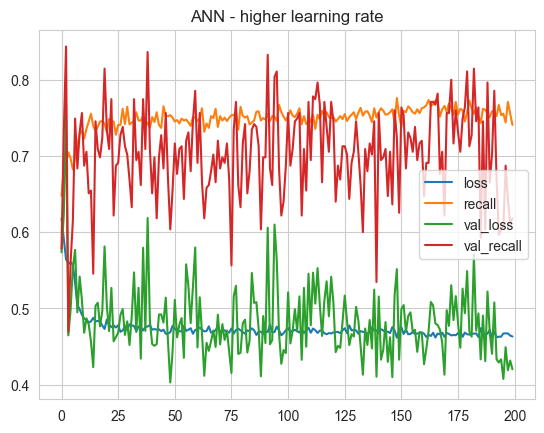

In [54]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('ANN - higher learning rate');

In [55]:
acc

,loss,recall,val_loss,val_recall
0,0.617889,0.647625,0.573631,0.578182
1,0.590668,0.682927,0.623148,0.730909
2,0.564518,0.689345,0.761915,0.843636
3,0.558569,0.704750,0.464608,0.469091
4,0.560334,0.697047,0.497892,0.560000
...,...,...,...,...
195,0.467066,0.755456,0.407413,0.607273
196,0.467211,0.743902,0.449107,0.687273
197,0.467090,0.770860,0.418790,0.643636
198,0.464339,0.756098,0.431542,0.610909


the results is not very good after assigning higher learning rate.

32/32 [==============================] - 0s 1ms/step
Model Evaluation
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       796
           1       0.54      0.73      0.62       204

    accuracy                           0.82      1000
   macro avg       0.73      0.78      0.75      1000
weighted avg       0.85      0.82      0.83      1000





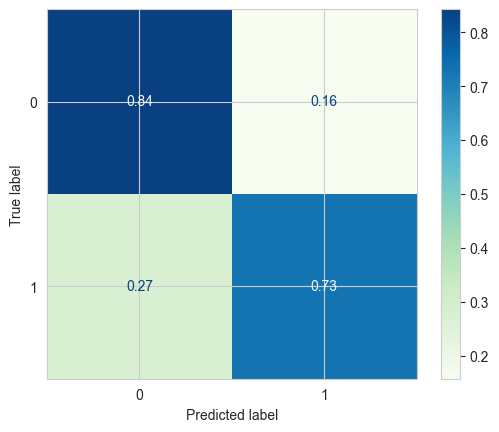

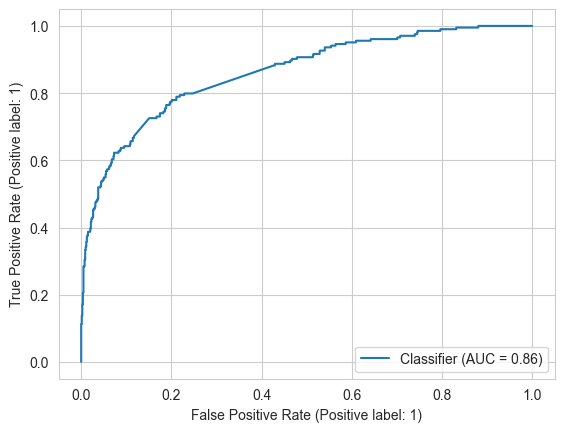

In [56]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

similar AUC results with alpha = 0.05

### Add Dropout Layer

In [57]:
set_seed() 

model = Sequential(
    [
        Input(shape = X_train.shape[1]), # input layer
        Dense(units = 20, activation = 'relu'), # hidden layer (1)
        Dropout(0.2), # dropout layer
        Dense(units = 10, activation = 'relu'), # hidden layer (2)
        Dropout(0.2), # dropout layer
        Dense(units = 1, activation ='sigmoid'), # output layer - binary classification
    ]
)

optimizer = Adam(learning_rate=0.005)  # testing lower learning rate
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])


model.fit(x = X_train, y = y_train,  validation_data = (X_val,y_val), 
          batch_size = 128, epochs = 500, class_weight=class_weights); #testing with more epochs

Epoch 1/500
60/60 [==============================] - 1s 5ms/step - loss: 0.6794 - recall: 0.5777 - val_loss: 0.6706 - val_recall: 0.7200
Epoch 2/500
60/60 [==============================] - 0s 3ms/step - loss: 0.6512 - recall: 0.6001 - val_loss: 0.5992 - val_recall: 0.6327
Epoch 3/500
60/60 [==============================] - 0s 3ms/step - loss: 0.6290 - recall: 0.6200 - val_loss: 0.6116 - val_recall: 0.6655
Epoch 4/500
60/60 [==============================] - 0s 3ms/step - loss: 0.6109 - recall: 0.6515 - val_loss: 0.5618 - val_recall: 0.6000
Epoch 5/500
60/60 [==============================] - 0s 3ms/step - loss: 0.5930 - recall: 0.6406 - val_loss: 0.5814 - val_recall: 0.6618
Epoch 6/500
60/60 [==============================] - 0s 2ms/step - loss: 0.5862 - recall: 0.6540 - val_loss: 0.6156 - val_recall: 0.7055
Epoch 7/500
60/60 [==============================] - 0s 2ms/step - loss: 0.5720 - recall: 0.6694 - val_loss: 0.5208 - val_recall: 0.6182
Epoch 8/500
60/60 [======================

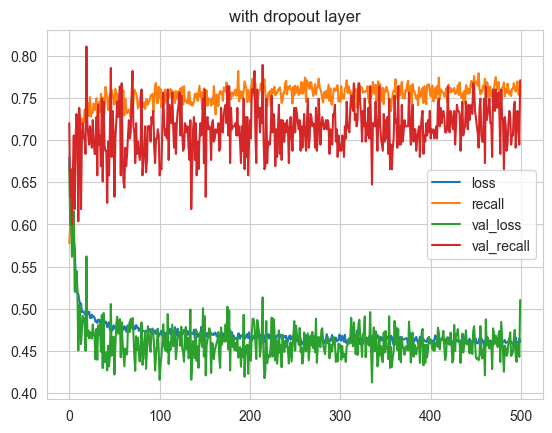

In [58]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('with dropout layer');

In [59]:
acc

,loss,recall,val_loss,val_recall
0,0.679388,0.577664,0.670614,0.720000
1,0.651184,0.600128,0.599155,0.632727
2,0.629021,0.620026,0.611578,0.665455
3,0.610915,0.651476,0.561793,0.600000
4,0.592974,0.640565,0.581431,0.661818
...,...,...,...,...
495,0.456682,0.761232,0.437162,0.709091
496,0.460236,0.769576,0.459425,0.734545
497,0.458293,0.754172,0.458427,0.723636
498,0.464998,0.753530,0.443067,0.694545


the loss is not improving much but recall scores are good on validation

32/32 [==============================] - 0s 1ms/step
Model Evaluation
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.75      0.83       796
           1       0.45      0.81      0.58       204

    accuracy                           0.76      1000
   macro avg       0.70      0.78      0.71      1000
weighted avg       0.84      0.76      0.78      1000





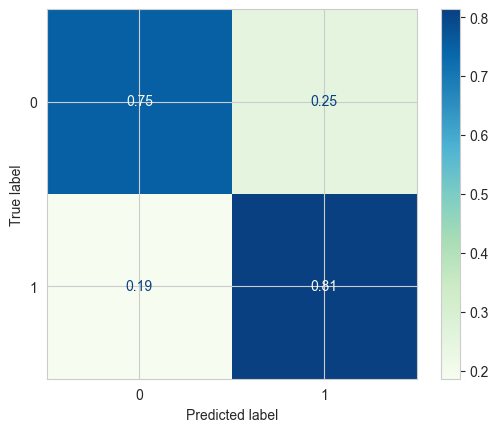

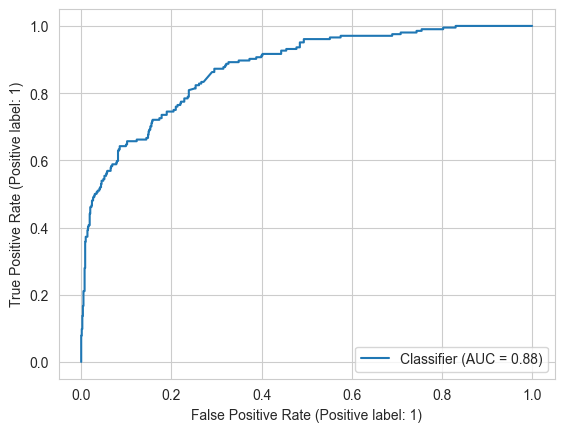

In [60]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

very good performance for class 1

### Add Early Stop

#### Monitor the "val_loss" as metric

In [61]:
set_seed()

model = Sequential(
    [
        Input(shape=X_train.shape[1]),  # input layer
        Dense(units=20, activation='relu'),  # hidden layer (1)
        Dropout(0.2),  # dropout layer
        Dense(units=10, activation='relu'),  # hidden layer (2)
        Dropout(0.2),  # dropout layer
        Dense(units=1, activation='sigmoid'), # output layer - binary classification
    ]
)

optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['Recall'])

early_stop = EarlyStopping(
    monitor='val_loss', mode='min', # minimize the loss
    verbose=1, patience=30, restore_best_weights=True)

model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
          batch_size=128, epochs=1000, class_weight=class_weights,
          callbacks=[early_stop])

Epoch 1/1000
60/60 [==============================] - 1s 5ms/step - loss: 0.6794 - recall: 0.5777 - val_loss: 0.6706 - val_recall: 0.7200
Epoch 2/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.6512 - recall: 0.6001 - val_loss: 0.5992 - val_recall: 0.6327
Epoch 3/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.6290 - recall: 0.6200 - val_loss: 0.6116 - val_recall: 0.6655
Epoch 4/1000
60/60 [==============================] - 0s 4ms/step - loss: 0.6109 - recall: 0.6515 - val_loss: 0.5618 - val_recall: 0.6000
Epoch 5/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5930 - recall: 0.6406 - val_loss: 0.5814 - val_recall: 0.6618
Epoch 6/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5862 - recall: 0.6540 - val_loss: 0.6156 - val_recall: 0.7055
Epoch 7/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5720 - recall: 0.6694 - val_loss: 0.5208 - val_recall: 0.6182
Epoch 8/1000
60/60 [==============

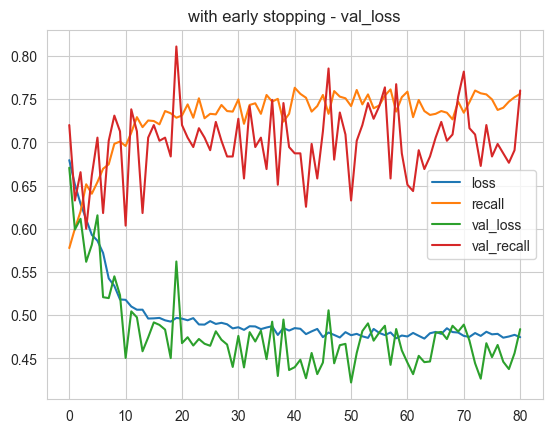

In [62]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('with early stopping - val_loss');

In [63]:
loss, recall = model.evaluate(X_test, y_test, verbose=0)
print('loss - ', loss)
print('recall - ', recall)

loss -  0.4045349657535553
recall -  0.7058823704719543


the monitored loss stoped improving at 81 epoch and the recall scores are not consistient

32/32 [==============================] - 0s 1ms/step
Model Evaluation
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       796
           1       0.56      0.71      0.62       204

    accuracy                           0.83      1000
   macro avg       0.74      0.78      0.76      1000
weighted avg       0.85      0.83      0.83      1000





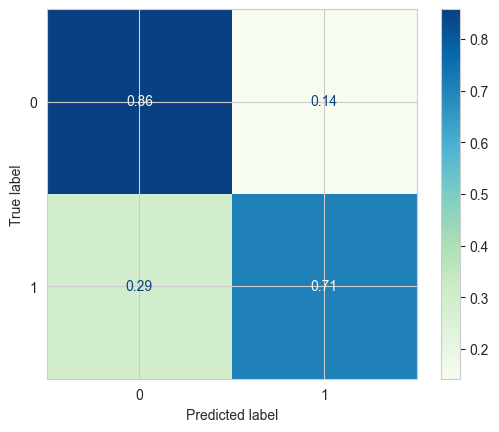

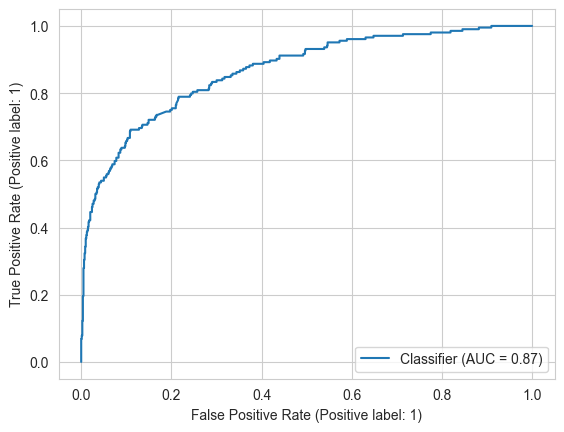

In [64]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

the recall scores are better for class 0 but needs improvments for class 1

#### Monitor the "val_recall" as metric

In [65]:
set_seed()

model = Sequential(
    [
        Input(shape=X_train.shape[1]),  # input layer
        Dense(units=20, activation='relu'),  # hidden layer (1)
        Dropout(0.2),  # dropout layer
        Dense(units=10, activation='relu'),  # hidden layer (2)
        Dropout(0.2),  # dropout layer
        # output layer - binary classification
        Dense(units=1, activation='sigmoid'),
    ]
)

optimizer = Adam(learning_rate=0.05)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['Recall'])

early_stop = EarlyStopping(
    monitor='val_recall', mode='max', # maximize
    verbose=1, patience=30, restore_best_weights=True)

model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
          batch_size=128, epochs=1000, class_weight=class_weights,
          callbacks=[early_stop])

Epoch 1/1000
60/60 [==============================] - 1s 5ms/step - loss: 0.6524 - recall: 0.6547 - val_loss: 0.6385 - val_recall: 0.6909
Epoch 2/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.6159 - recall: 0.6117 - val_loss: 0.5473 - val_recall: 0.5309
Epoch 3/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.6083 - recall: 0.5886 - val_loss: 0.6676 - val_recall: 0.7891
Epoch 4/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.6000 - recall: 0.7131 - val_loss: 0.5250 - val_recall: 0.5018
Epoch 5/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5905 - recall: 0.6579 - val_loss: 0.6191 - val_recall: 0.6982
Epoch 6/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5956 - recall: 0.6630 - val_loss: 0.5385 - val_recall: 0.5600
Epoch 7/1000
60/60 [==============================] - 0s 3ms/step - loss: 0.5973 - recall: 0.6194 - val_loss: 0.5801 - val_recall: 0.6000
Epoch 8/1000
60/60 [==============

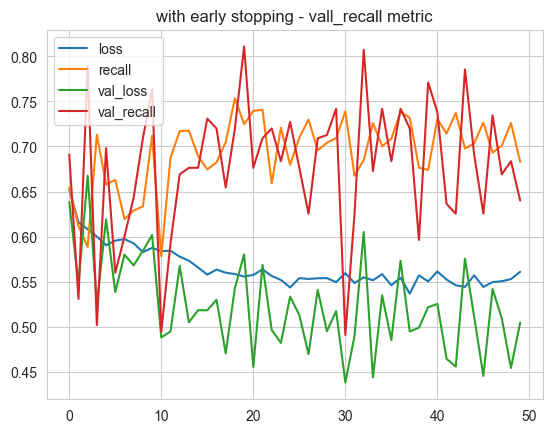

In [66]:
acc = pd.DataFrame(model.history.history)
acc.plot()
plt.title('with early stopping - vall_recall metric');

In [67]:
loss, recall = model.evaluate(X_test, y_test, verbose=0)
print('loss - ', loss)
print('recall - ', recall)

loss -  0.5831610560417175
recall -  0.843137264251709


The loss is too high

32/32 [==============================] - 0s 1ms/step
Model Evaluation
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.62      0.74       796
           1       0.36      0.84      0.50       204

    accuracy                           0.66      1000
   macro avg       0.65      0.73      0.62      1000
weighted avg       0.82      0.66      0.69      1000





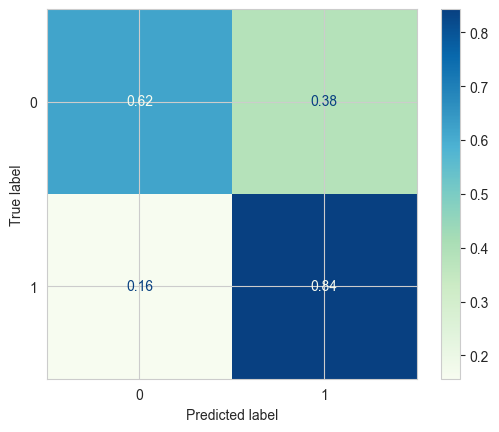

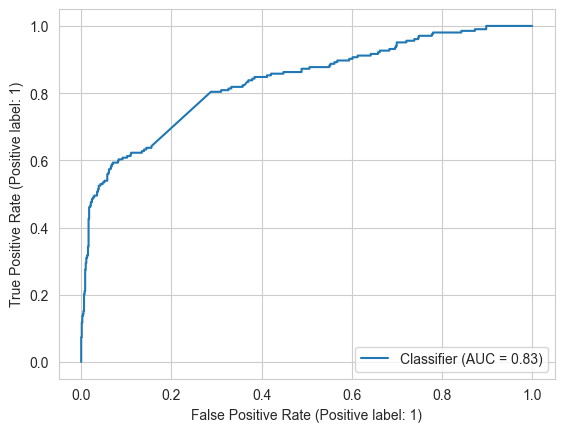

In [68]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

Class 0 performed very badly compared to class 1 recall <br>
for the hyperparameter tunning we will use val_loss for the early stopping and try to find a good balance

## Optuna

Optuna is an open-source hyperparameter optimization framework. <br> This framework is much faster than GridSearch, it intelligently suggests new sets of hyperparameters based on the performance of previously evaluated sets. It utilizes techniques such as Bayesian optimization to balance exploration and exploitation.

In [38]:
# comment this later,,, just because I restarted the kernel and don't want to re-run everyting 
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weights = {0: class_weights[0], 1: class_weights[1]}

In [39]:
# early stopping using val_loss
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=0, #logging off
    patience=30,
    restore_best_weights=True
)

Our hyperparameter tunning strategy is to conduct two studies:

<b>Study 1</b>
- Find the best weight for class 1 (w1) while setting class 0 (w0) as the previuosly assigned weight
- Find the best leraning rate 
- Use recall a metric to improve the classes performance
- Discuss the results

<b>Study 2</b>
- Use the best optimal hyperparameter from the previos study (alpha and w1)
- Find optimal optimizer
- Find best droupout rate
- Find best no. of units for hidden layer 1
- Find best no. of units for hidden layer 2
- Use AUC score as a metric to improve the overall performance 

In [36]:
# optuna.logging.set_verbosity(optuna.logging.WARNING) # to only show warnings

In [40]:
def objective(trial, early_stop=early_stop):
    """ This function create a new trial to find the optimal hyperparameters

    Args:
        trial : optuna object
        early_stop : The early stopping callback. Defaults to early_stop.


    Returns:
        float: recal score
    """

    # testing with alpha and class 1 weight
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)  # values ranging from 0.001 - 0.01
    w1 = trial.suggest_loguniform('w1', 2, 4)    # values from 2 to 4 including floating points

    set_seed()

    model = Sequential(
        [
            Input(shape=X_train.shape[1]),
            Dense(units=20, activation='relu'),
            Dropout(0.2),
            Dense(units=10, activation='relu'),
            Dropout(0.2),
            Dense(units=1, activation='sigmoid'),
        ]
    )

    optimizer = Adam(learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', 
                  metrics=['Recall'])

    model.fit(x=X_train, y=y_train, 
              validation_data=(X_val,y_val),
              batch_size=128, epochs=1000, 
              class_weight={0: class_weights[0], 1: w1}, # class 0 weight is fixed
              verbose=0, # logging off
              callbacks=[early_stop])

    # score on train set only
    # scoring for ecall
    y_pred = model.predict(X_train) > 0.5  # threshold at 50%
    recall = recall_score(y_pred=y_pred, y_true=y_train) 
    return recall

study = optuna.create_study(direction='maximize', study_name='Finding optimal values')
study.optimize(objective, n_trials=20)

print('Best trial: {}'.format(study.best_trial.number))
print('Recall score: {}'.format(study.best_trial.value))
print('Best hyperparameters: {}'.format(study.best_params))

[I 2023-10-29 23:41:58,419] A new study created in memory with name: Finding optimal values


240/240 [==============================] - 0s 855us/step


[I 2023-10-29 23:42:07,677] Trial 0 finished with value: 0.7227214377406932 and parameters: {'learning_rate': 0.007284751511517249, 'w1': 3.1532869363742067}. Best is trial 0 with value: 0.7227214377406932.


240/240 [==============================] - 0s 885us/step


[I 2023-10-29 23:42:17,545] Trial 1 finished with value: 0.6424903722721438 and parameters: {'learning_rate': 0.0024539137715575425, 'w1': 2.0646749285248958}. Best is trial 0 with value: 0.7227214377406932.


240/240 [==============================] - 0s 920us/step


[I 2023-10-29 23:42:26,061] Trial 2 finished with value: 0.6810012836970475 and parameters: {'learning_rate': 0.004192398472531039, 'w1': 2.202475695789784}. Best is trial 0 with value: 0.7227214377406932.


240/240 [==============================] - 0s 2ms/step


[I 2023-10-29 23:42:35,481] Trial 3 finished with value: 0.7329910141206675 and parameters: {'learning_rate': 0.0026074042274383384, 'w1': 2.7369043303324108}. Best is trial 3 with value: 0.7329910141206675.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:42:46,897] Trial 4 finished with value: 0.7580231065468549 and parameters: {'learning_rate': 0.0013264823985771133, 'w1': 3.062789495707478}. Best is trial 4 with value: 0.7580231065468549.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:43:05,711] Trial 5 finished with value: 0.766367137355584 and parameters: {'learning_rate': 0.0010630814358782556, 'w1': 2.885809891066853}. Best is trial 5 with value: 0.766367137355584.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:43:15,521] Trial 6 finished with value: 0.7098844672657253 and parameters: {'learning_rate': 0.009826364875495635, 'w1': 2.4851718471471806}. Best is trial 5 with value: 0.766367137355584.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:43:25,611] Trial 7 finished with value: 0.6630295250320924 and parameters: {'learning_rate': 0.005707058953855903, 'w1': 2.416517223489188}. Best is trial 5 with value: 0.766367137355584.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:43:35,545] Trial 8 finished with value: 0.634788189987163 and parameters: {'learning_rate': 0.0027980860798600274, 'w1': 2.093527190344035}. Best is trial 5 with value: 0.766367137355584.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:43:55,327] Trial 9 finished with value: 0.79204107830552 and parameters: {'learning_rate': 0.0010533275846319329, 'w1': 3.1330703175708328}. Best is trial 9 with value: 0.79204107830552.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:44:07,481] Trial 10 finished with value: 0.8145057766367138 and parameters: {'learning_rate': 0.001649609821457966, 'w1': 3.7388068067567537}. Best is trial 10 with value: 0.8145057766367138.


240/240 [==============================] - 0s 919us/step


[I 2023-10-29 23:44:20,231] Trial 11 finished with value: 0.810012836970475 and parameters: {'learning_rate': 0.001607965975747915, 'w1': 3.7147950656553723}. Best is trial 10 with value: 0.8145057766367138.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:44:32,377] Trial 12 finished with value: 0.8145057766367138 and parameters: {'learning_rate': 0.001682395642146096, 'w1': 3.863580837445291}. Best is trial 10 with value: 0.8145057766367138.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:44:44,100] Trial 13 finished with value: 0.8254172015404364 and parameters: {'learning_rate': 0.0018074579609088203, 'w1': 3.962624777097124}. Best is trial 13 with value: 0.8254172015404364.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:44:56,091] Trial 14 finished with value: 0.8369704749679076 and parameters: {'learning_rate': 0.002024525736193292, 'w1': 3.9653004890482424}. Best is trial 14 with value: 0.8369704749679076.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:45:06,300] Trial 15 finished with value: 0.8029525032092426 and parameters: {'learning_rate': 0.0021645814163829074, 'w1': 3.982108059227007}. Best is trial 14 with value: 0.8369704749679076.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:45:16,460] Trial 16 finished with value: 0.7496790757381258 and parameters: {'learning_rate': 0.0034373488668236513, 'w1': 3.48442935453582}. Best is trial 14 with value: 0.8369704749679076.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:45:26,581] Trial 17 finished with value: 0.7952503209242618 and parameters: {'learning_rate': 0.0021502385325096033, 'w1': 3.5273336639479314}. Best is trial 14 with value: 0.8369704749679076.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:45:37,360] Trial 18 finished with value: 0.8061617458279846 and parameters: {'learning_rate': 0.003177670641241751, 'w1': 3.992252089729939}. Best is trial 14 with value: 0.8369704749679076.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-29 23:45:49,150] Trial 19 finished with value: 0.7997432605905006 and parameters: {'learning_rate': 0.0019410262440272253, 'w1': 3.370280713767457}. Best is trial 14 with value: 0.8369704749679076.


Best trial: 14
Recall score: 0.8369704749679076
Best hyperparameters: {'learning_rate': 0.002024525736193292, 'w1': 3.9653004890482424}


In [41]:
optuna.visualization.plot_optimization_history(study)

If picture not showing in browser <br> <br>
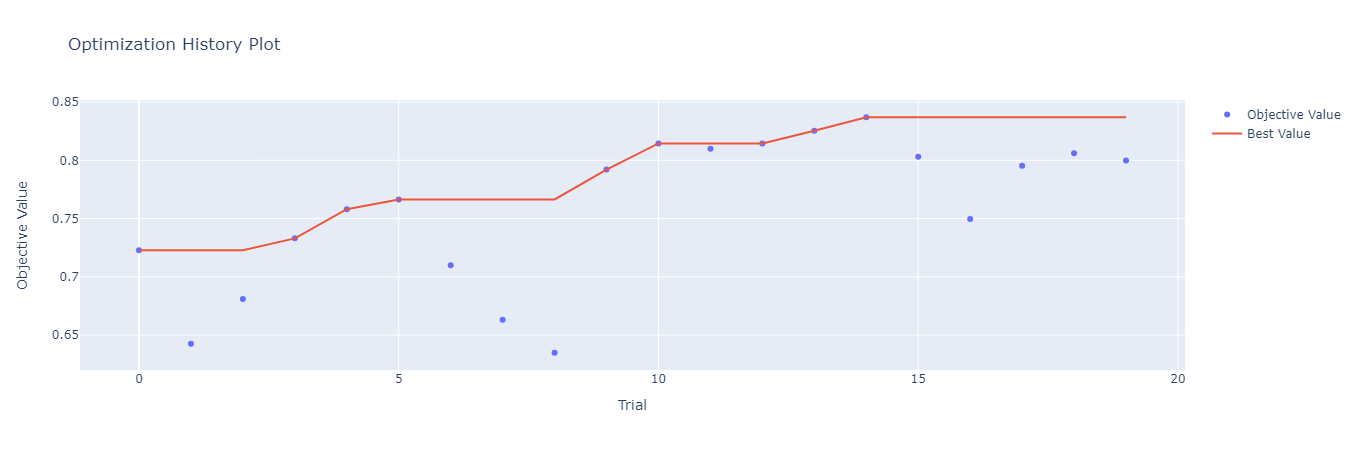

In [42]:
optuna.visualization.plot_slice(study)

If picture not showing in broweser <br>
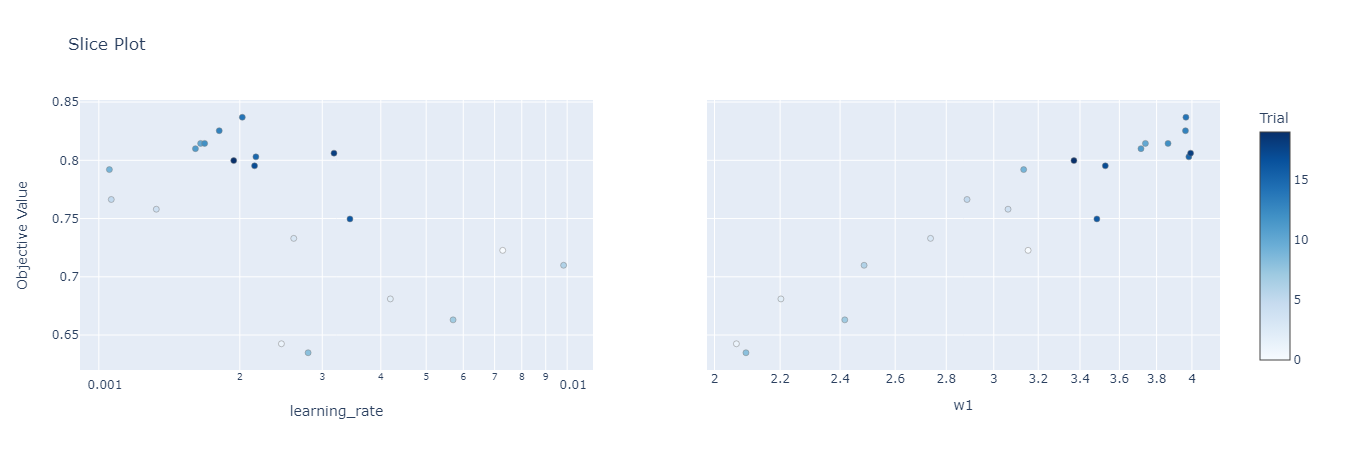

In [43]:
learning_rate = study.best_params['learning_rate'] #from study 1
w1 = study.best_params['w1'] #from study 1

model = Sequential(
         [
        Input(shape = X_train.shape[1]), 
        Dense(units = 20, activation = 'relu'), 
        Dropout(0.2), 
        Dense(units = 10, activation = 'relu'),
        Dropout(0.2), 
        Dense(units = 1, activation ='sigmoid'), 
            ]
        )
optimizer = Adam(learning_rate)  
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['Recall'])

model.fit(x=X_train, y=y_train, validation_data=(X_val,y_val),
              batch_size=128, epochs=1000, class_weight={0: class_weights[0], 1: w1}, verbose = 0, #logging off
              callbacks=[early_stop])


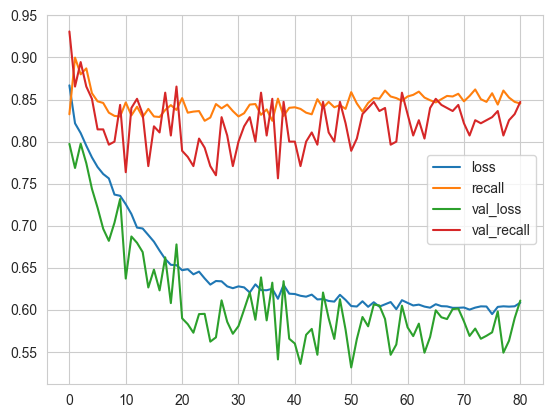

In [44]:
acc = pd.DataFrame(model.history.history)
acc.plot();

In [45]:
acc

,loss,recall,val_loss,val_recall
0,0.866862,0.832478,0.797375,0.930909
1,0.821758,0.899872,0.768673,0.865455
2,0.810170,0.879974,0.797509,0.894545
3,0.795135,0.887035,0.774315,0.865455
4,0.781244,0.857510,0.743888,0.850909
...,...,...,...,...
76,0.603598,0.844031,0.598187,0.836364
77,0.604278,0.860719,0.549183,0.807273
78,0.603891,0.852375,0.563410,0.825455
79,0.604289,0.847240,0.590198,0.832727


In [46]:
df_scores = pd.DataFrame(
    {'mean': acc.mean().values, 'std': acc.std().values},
    index=['loss', 'recall', 'val_loss', 'val_recall'],
)
df_scores

,mean,std
loss,0.644202,0.060621
recall,0.845283,0.012826
val_loss,0.610890,0.060437
val_recall,0.820875,0.030693


the model performance is good but the scores can be improved more (for loss)

32/32 [==============================] - 0s 1ms/step
Model Evaluation
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       796
           1       0.43      0.81      0.57       204

    accuracy                           0.74      1000
   macro avg       0.69      0.77      0.69      1000
weighted avg       0.84      0.74      0.77      1000





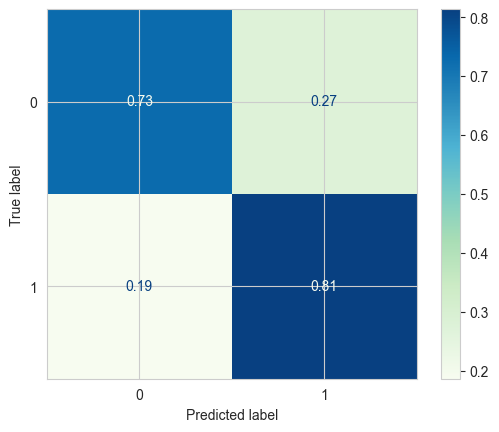

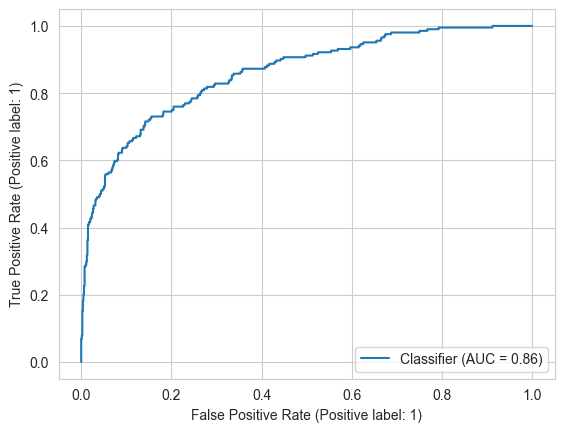

In [47]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

- Our objective was obtained (maximize the recall for class 1)
- I would say that these results are reasonably good given the complexity of this problem
- From a business prospective; class 1 is more important to take actions before the customer actually leave the bank. 


In [72]:
def objective(trial, early_stop=early_stop):
    """ This function create a new trial to find the optimal hyperparameters

    Args:
        trial : optuna object
        early_stop : The early stopping callback. Defaults to early_stop.


    Returns:
        float: auc score 
    """

    # parameters to be searched
    optimizer = trial.suggest_categorical('optimizer', [Adam, Adadelta, RMSprop, Nadam])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 1.0) # including float points
    units_layer1 = trial.suggest_int('units_layer1', 16, 64) # only int
    units_layer2 = trial.suggest_int('units_layer2', 8, 32) # only int
    
    set_seed()

    model = Sequential(
        [
            # test suggested params in the archticture
            Input(shape=X_train.shape[1]),
            Dense(units=units_layer1, activation='relu'),
            Dropout(dropout_rate),
            Dense(units=units_layer2, activation='relu'),
            Dropout(dropout_rate),
            Dense(units=1, activation='sigmoid'),
        ]
    )

    opt = optimizer(learning_rate) # from study 1
    model.compile(optimizer=opt,
                  loss='binary_crossentropy', 
                  metrics=['Recall'])

    model.fit(x=X_train, y=y_train, 
              validation_data=(X_val,y_val),
              batch_size=128, epochs=1000, 
              class_weight={0: class_weights[0], 1: w1}, # w1 from study 1
              verbose=0, # logging off
              callbacks=[early_stop])

    # scoring for auc # train set
    y_pred = model.predict(X_train) # probs
    auc = roc_auc_score(y_score=y_pred, y_true=y_train, average='weighted') # weighted auc for imbalanced binary classes
    return auc

#stury 2
study = optuna.create_study(direction='maximize', study_name='Finding optimal values 2')
study.optimize(objective, n_trials=20)

print('Best trial: {}'.format(study.best_trial.number))
print('AUC-ROC score: {}'.format(study.best_trial.value))
print('Best hyperparameters: {}'.format(study.best_params))

[I 2023-10-30 00:06:00,011] A new study created in memory with name: Finding optimal values 2


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:06:12,655] Trial 0 finished with value: 0.8690769666146052 and parameters: {'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'dropout_rate': 0.46505259826847917, 'units_layer1': 64, 'units_layer2': 23}. Best is trial 0 with value: 0.8690769666146052.


240/240 [==============================] - 0s 953us/step


[I 2023-10-30 00:06:28,365] Trial 1 finished with value: 0.845742949148571 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.6716537466532388, 'units_layer1': 26, 'units_layer2': 13}. Best is trial 0 with value: 0.8690769666146052.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:09:03,897] Trial 2 finished with value: 0.7214849416351924 and parameters: {'optimizer': <class 'keras.src.optimizers.adadelta.Adadelta'>, 'dropout_rate': 0.25667880597892884, 'units_layer1': 62, 'units_layer2': 27}. Best is trial 0 with value: 0.8690769666146052.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:09:10,111] Trial 3 finished with value: 0.6087073516310032 and parameters: {'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'dropout_rate': 0.8997625299407523, 'units_layer1': 34, 'units_layer2': 9}. Best is trial 0 with value: 0.8690769666146052.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:09:15,814] Trial 4 finished with value: 0.5247918206667639 and parameters: {'optimizer': <class 'keras.src.optimizers.adadelta.Adadelta'>, 'dropout_rate': 0.7235302462285984, 'units_layer1': 26, 'units_layer2': 14}. Best is trial 0 with value: 0.8690769666146052.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:09:21,694] Trial 5 finished with value: 0.5862058302434979 and parameters: {'optimizer': <class 'keras.src.optimizers.adadelta.Adadelta'>, 'dropout_rate': 0.3498181829823317, 'units_layer1': 44, 'units_layer2': 14}. Best is trial 0 with value: 0.8690769666146052.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:09:33,604] Trial 6 finished with value: 0.8764226658923464 and parameters: {'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'dropout_rate': 0.2047926504818549, 'units_layer1': 60, 'units_layer2': 29}. Best is trial 6 with value: 0.8764226658923464.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:09:50,297] Trial 7 finished with value: 0.8648889366049205 and parameters: {'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'dropout_rate': 0.5300000662210846, 'units_layer1': 33, 'units_layer2': 14}. Best is trial 6 with value: 0.8764226658923464.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:09:56,324] Trial 8 finished with value: 0.5683411692516206 and parameters: {'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'dropout_rate': 0.999459618834549, 'units_layer1': 51, 'units_layer2': 27}. Best is trial 6 with value: 0.8764226658923464.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:10:02,359] Trial 9 finished with value: 0.6499577614784684 and parameters: {'optimizer': <class 'keras.src.optimizers.adadelta.Adadelta'>, 'dropout_rate': 0.75381412772346, 'units_layer1': 29, 'units_layer2': 13}. Best is trial 6 with value: 0.8764226658923464.


240/240 [==============================] - 0s 963us/step


[I 2023-10-30 00:10:15,804] Trial 10 finished with value: 0.8745472713219721 and parameters: {'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'dropout_rate': 0.24248751272388905, 'units_layer1': 54, 'units_layer2': 31}. Best is trial 6 with value: 0.8764226658923464.


240/240 [==============================] - 0s 962us/step


[I 2023-10-30 00:10:29,984] Trial 11 finished with value: 0.8758015731399668 and parameters: {'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'dropout_rate': 0.22417509424562038, 'units_layer1': 54, 'units_layer2': 32}. Best is trial 6 with value: 0.8764226658923464.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:10:44,413] Trial 12 finished with value: 0.867097108352291 and parameters: {'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'dropout_rate': 0.21020868746166305, 'units_layer1': 16, 'units_layer2': 32}. Best is trial 6 with value: 0.8764226658923464.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:10:59,333] Trial 13 finished with value: 0.8702096311836394 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.3802825680809596, 'units_layer1': 54, 'units_layer2': 27}. Best is trial 6 with value: 0.8764226658923464.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:11:13,083] Trial 14 finished with value: 0.8720932437751651 and parameters: {'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'dropout_rate': 0.3405201884688503, 'units_layer1': 46, 'units_layer2': 20}. Best is trial 6 with value: 0.8764226658923464.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:11:26,254] Trial 15 finished with value: 0.8782256786610442 and parameters: {'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'dropout_rate': 0.20607949419394878, 'units_layer1': 59, 'units_layer2': 30}. Best is trial 15 with value: 0.8782256786610442.


240/240 [==============================] - 0s 2ms/step


[I 2023-10-30 00:11:39,903] Trial 16 finished with value: 0.8667934103270605 and parameters: {'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'dropout_rate': 0.44419343595691374, 'units_layer1': 60, 'units_layer2': 22}. Best is trial 15 with value: 0.8782256786610442.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:11:54,463] Trial 17 finished with value: 0.8666499110346533 and parameters: {'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'dropout_rate': 0.5551857243540133, 'units_layer1': 58, 'units_layer2': 29}. Best is trial 15 with value: 0.8782256786610442.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:12:11,557] Trial 18 finished with value: 0.8777060468621066 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.3079915625527403, 'units_layer1': 47, 'units_layer2': 23}. Best is trial 15 with value: 0.8782256786610442.


240/240 [==============================] - 0s 1ms/step


[I 2023-10-30 00:12:25,733] Trial 19 finished with value: 0.8758946053537668 and parameters: {'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>, 'dropout_rate': 0.3122305570744225, 'units_layer1': 41, 'units_layer2': 24}. Best is trial 15 with value: 0.8782256786610442.


Best trial: 15
AUC-ROC score: 0.8782256786610442
Best hyperparameters: {'optimizer': <class 'keras.src.optimizers.nadam.Nadam'>, 'dropout_rate': 0.20607949419394878, 'units_layer1': 59, 'units_layer2': 30}


In [73]:
optuna.visualization.plot_optimization_history(study)

If pic not showing: <br>
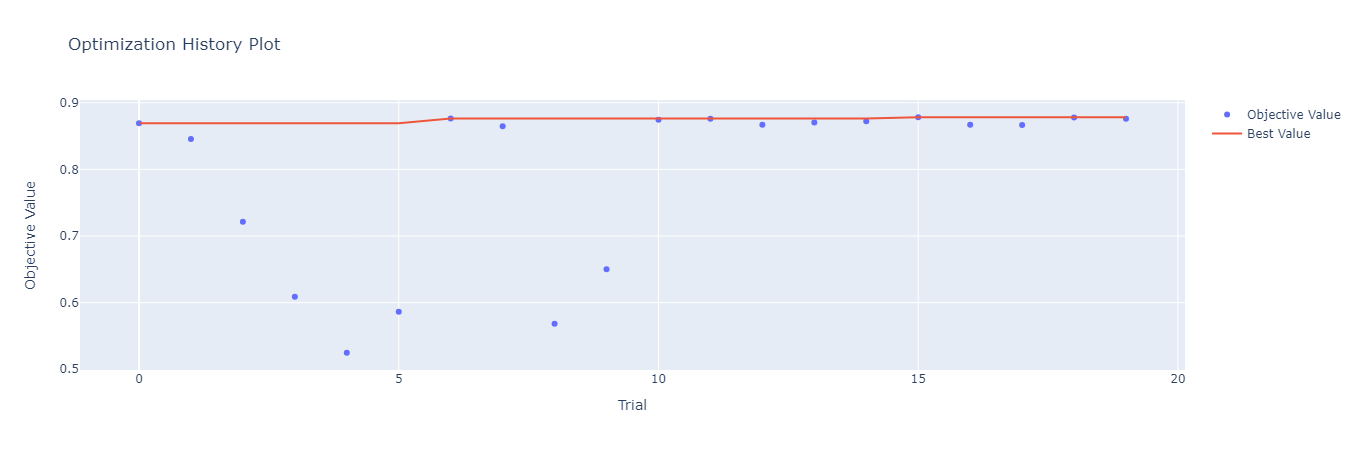

In [91]:
study.best_params

{'optimizer': keras.src.optimizers.nadam.Nadam,
 'dropout_rate': 0.20607949419394878,
 'units_layer1': 59,
 'units_layer2': 30}

In [92]:
d = study.best_params['dropout_rate']
u1 = study.best_params['units_layer1']
u2 = study.best_params['units_layer2']

Evaluate tuned model

In [93]:
set_seed() 

model = Sequential(
         [
        Input(shape = X_train.shape[1]), 
        Dense(units = u1, activation = 'relu'), 
        Dropout(d), 
        Dense(units = u2, activation = 'relu'),
        Dropout(d), 
        Dense(units = 1, activation ='sigmoid'), 
            ]
        )

model.compile(optimizer = Nadam(learning_rate), loss = 'binary_crossentropy', metrics=['Recall'])

model.fit(x=X_train, y=y_train, 
              validation_data=(X_val,y_val),
              batch_size=128, epochs=1000, 
              class_weight={0: class_weights[0], 1: w1},
              verbose=0,
              callbacks=[early_stop])

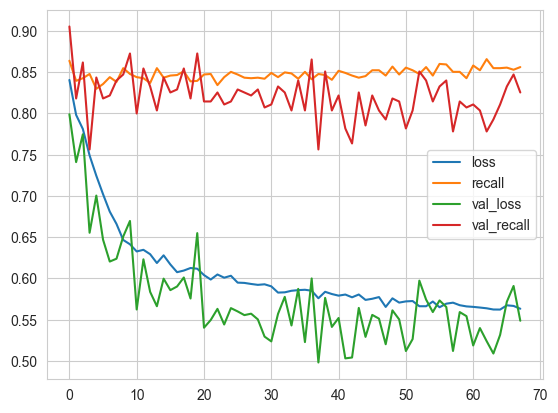

In [94]:
acc = pd.DataFrame(model.history.history)
acc.plot();

In [95]:
acc[:5]

,loss,recall,val_loss,val_recall
0,0.840629,0.863928,0.799029,0.905455
1,0.798267,0.839538,0.741027,0.818182
2,0.781180,0.842747,0.774764,0.861818
3,0.749150,0.847882,0.655406,0.756364
4,0.724532,0.829910,0.700457,0.843636


In [96]:
df_scores = pd.DataFrame(
    {'mean': acc.mean().values, 'std': acc.std().values},
    index=['loss', 'recall', 'val_loss', 'val_recall'],
)
df_scores

,mean,std
loss,0.606096,0.057884
recall,0.847872,0.006896
val_loss,0.575425,0.059811
val_recall,0.820588,0.027245


After multiple expermients the results doesn't get much better but the recall results look good. 

In [97]:
loss, recall = model.evaluate(X_test, y_test, verbose=0)
print('loss - ', loss)
print('recall - ', recall)

loss -  0.5011381506919861
recall -  0.813725471496582


32/32 [==============================] - 0s 1ms/step
Model Evaluation
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       796
           1       0.46      0.81      0.59       204

    accuracy                           0.77      1000
   macro avg       0.70      0.78      0.71      1000
weighted avg       0.84      0.77      0.79      1000





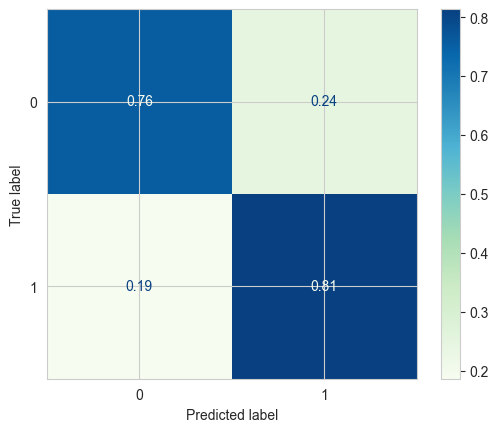

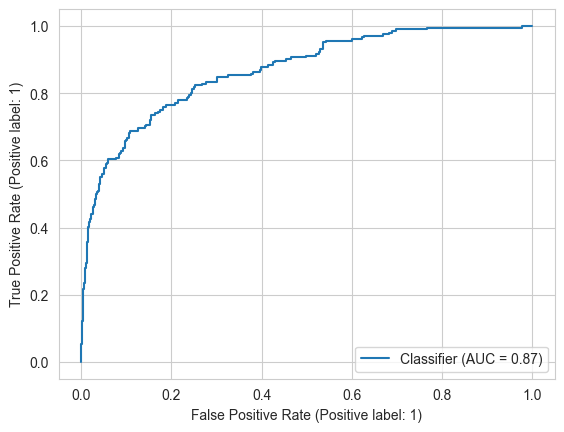

In [98]:
y_pred = model.predict(X_test) 
eval_metric(y_pred, y_test) 

## displaying ROC curve for each class

In [99]:
auc_class_0 = roc_auc_score(1 - y_test, 1 - y_pred) # get probs for 0
auc_class_1 = roc_auc_score(y_test, y_pred) # get probs for 1

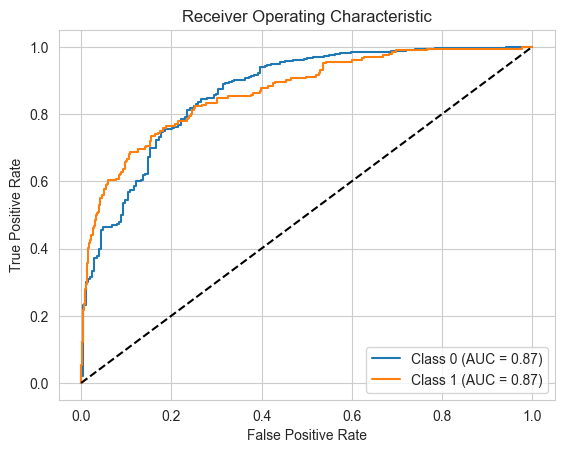

In [100]:
# calculating the ROC curve for class 0
fpr_class_0, tpr_class_0, _ = roc_curve(1 - y_test, 1 - y_pred)
auc_class_0 = roc_auc_score(1 - y_test, 1 - y_pred)

# calculating the ROC curve for class 1
fpr_class_1, tpr_class_1, _ = roc_curve(y_test, y_pred)
auc_class_1 = roc_auc_score(y_test, y_pred)

plt.plot(fpr_class_0, tpr_class_0, label='Class 0 (AUC = {:.2f})'.format(auc_class_0))
plt.plot(fpr_class_1, tpr_class_1, label='Class 1 (AUC = {:.2f})'.format(auc_class_1))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Both classes have AUC score of 0.87 which tells us that the model overall performance is very good. 

## Cross Validation

To validated the results using cross validation we will wrap our keras model in the KerasClassifier from sklearn

In [101]:
def create_model():
        """ create ann model with specific archticture

        Returns:
        kears model
        
        """
        set_seed() 
        # model with best archticture
        model = Sequential([
        Input(shape=X_train.shape[1]),
        Dense(units=u1, activation='relu'),
        Dropout(d),
        Dense(units=u2, activation='relu'),
        Dropout(d),
        Dense(units=1, activation='sigmoid')
        ])
    
        model.compile(optimizer=Nadam(learning_rate), loss='binary_crossentropy', metrics=['Recall'])
    
        return model


In [102]:
model = KerasClassifier(build_fn=create_model, batch_size=128, epochs=100,
                        class_weight={0: class_weights[0], 1: w1},
                        verbose=0)

scores = cross_validate(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring=['balanced_accuracy', 'precision', 'recall', 'f1'],
    cv=10,
    n_jobs=-1
)

cross_val = pd.DataFrame(scores, index=range(1, 11)).iloc[:, 2:]

cross_val

,test_balanced_accuracy,test_precision,test_recall,test_f1
1,0.748414,0.404605,0.793548,0.535948
2,0.752618,0.418685,0.780645,0.545045
3,0.775294,0.423077,0.846154,0.564103
4,0.801566,0.471429,0.846154,0.605505
5,0.757784,0.418060,0.801282,0.549451
6,0.769783,0.424342,0.826923,0.560870
7,0.752037,0.408497,0.801282,0.541126
8,0.762978,0.403670,0.846154,0.546584
9,0.781862,0.434211,0.846154,0.573913
10,0.772483,0.440559,0.807692,0.570136


The recall scores are consistent and balanced accuracy is reasonable

In [103]:
df_scores = pd.DataFrame(
    {'mean': cross_val.mean().values, 'std': cross_val.std().values},
    index=['balanced_accuracy', 'precision', 'recall', 'f1'],
)

df_scores

,mean,std
balanced_accuracy,0.767482,0.016321
precision,0.424713,0.020323
recall,0.819599,0.025567
f1,0.559268,0.020626


all scores are close to the average value

## Final Model and final thoughts

Best params: <br>
Best hyperparameters: {'learning_rate': 0.002024525736193292, <br>
 'w1': 3.9653004890482424} <br>
{'optimizer': <br>
keras.src.optimizers.nadam.Nadam, <br>
 'dropout_rate': 0.20607949419394878, <br>
 'units_layer1': 59, <br>
 'units_layer2': 30} <br>

In [104]:
set_seed() 


model = Sequential(
         [
        Input(shape = X_train.shape[1]), 
        Dense(units = u1 , activation = 'relu'), 
        Dropout(d), 
        Dense(units = u2, activation = 'relu'),
        Dropout(d), 
        Dense(units = 1, activation ='sigmoid'), 
            ]
        )

model.compile(optimizer = Nadam(learning_rate), loss = 'binary_crossentropy', metrics=['Recall'])

model.fit(x=X_train, y=y_train, 
              validation_data=(X_val, y_val),
              batch_size=128, epochs=1000, 
              class_weight={0: class_weights[0], 1: w1},
              verbose=0,
              callbacks=[early_stop])

In [105]:
loss, recall = model.evaluate(X_test, y_test, verbose=0)
print('loss - ', loss)
print('recall - ', recall)

loss -  0.5011381506919861
recall -  0.813725471496582


In [106]:
y_pred = model.predict(X_test)
roc_auc_score(y_score=y_pred, y_true=y_test, average='weighted')

32/32 [==============================] - 0s 1ms/step


0.8677455906985911

- Our ANN model has successfully identified around 81.3% of the positive instances.
- Our model has performed quite well and achieved an AUC score of 86. <br>
However, the loss is not very good (loss is 0.50) and might be improved further to reach 0.45 or 0.4 using different approaches that require higher computational power and time (or more data), which unfortunately I don't have at the moment :(


## Model and scaler saving

saving the final model, scaler, transformer

In [107]:
model.save('churn_pred.keras')
pickle.dump(minmax_scaler, open('ann_scaler.sav', 'wb'))
pickle.dump(column_trans, open('ann_trans.sav', 'wb'))

loading the model

In [54]:
trained_model = load_model('churn_pred.keras')
scaler = pickle.load(open('ann_scaler.sav', 'rb'))
transformer = pickle.load(open('ann_trans.sav', 'rb'))

## Prediction

Since we are using column transform we must pass the feature with thier values to be one-hot encoded 

In [55]:
rand_costumer = df.drop('Exited', axis=1).sample(10)
rand_costumer

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9920,678,France,Female,49,3,204510.94,1,0,1,738.88
6401,556,France,Female,46,10,0.00,2,0,0,109184.24
1063,812,France,Male,34,5,103818.43,1,1,1,166038.27
6167,657,Spain,Male,75,7,126273.95,1,0,1,91673.60
2339,651,Germany,Male,26,5,147037.32,1,0,0,141763.26
2283,702,France,Male,45,9,74989.58,1,1,1,171014.69
428,486,Germany,Female,40,9,71340.09,1,1,0,76192.21
1143,630,France,Male,43,9,0.00,2,1,1,34338.04
8620,768,France,Female,40,8,0.00,2,0,1,69080.46
3588,489,Spain,Male,40,3,221532.80,1,1,0,171867.08


In [56]:
c1 = transformer.fit_transform(rand_costumer)
c1 = scaler.fit_transform(c1)
c1.shape

(10, 15)

In [57]:
c1[:1] # pass one row 

array([[0.        , 1.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 0.58895706,
        0.46938776, 0.        , 0.92316325, 0.        , 0.        ]])

In [58]:
((trained_model.predict(c1[:1]) > 0.5).astype('int'))

1/1 [==============================] - 0s 50ms/step


array([[1]])

the model predicted that the customer is going to close thier account

In [59]:
df.iloc[9920]

CreditScore              678
Geography             France
Gender                Female
Age                       49
Tenure                     3
Balance            204510.94
NumOfProducts              1
HasCrCard                  0
IsActiveMember             1
EstimatedSalary       738.88
Exited                     1
Name: 9920, dtype: object

this was a correct prediction 

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___